In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

import numpy as np

In [ ]:
def v_prime(v):
    x = v[0]
    y = v[1]

    rot = np.stack((-y, x))
    out = np.stack((x, y))

    return rot + 0.2 * out

def jacobian(v, dt):
    x = v[0]
    y = v[1]

    rot_jac = np.array(
       [[0, -1],
        [1, 0]]
    )

    out_jac = np.array(
       [[1, 0],
        [0, 1]]
    )

    return np.eye(2) + dt * (rot_jac + 0.2 * out_jac)

def euler_step(v, dt):
    return v + dt * v_prime(v)

def compute_path(v, t, compute_jacs=False):
    paths = np.zeros((len(t), len(v)))
    paths[0] = v

    n = v.shape[0]

    for i in range(len(t)-1):
        paths[i+1] = euler_step(paths[i], t[i+1] - t[i])
        # cum_grad = jacobian(paths[i], t[i+1] - t[i]) @ cum_grad

    jacobians = None
    if compute_jacs:
        jacobians = np.zeros((len(t), n, n))

        jacobians[-1] = np.eye(n)
        for i in range(len(t)-2, -1, -1):
            jacobians[i] = jacobians[i+1] @ jacobian(paths[i], t[i+1] - t[i])

        return paths, jacobians
    return paths

v0 = np.array([-1, 1])
epsilon = 0.15
arrow_len = 0.3 / epsilon

ep_x = epsilon * np.array([1, 0])
ep_y = epsilon * np.array([0, 1])

ts = np.linspace(0, 7, 1001)
path, jacobians = compute_path(v0, ts, compute_jacs=True)
path_x = compute_path(v0 + ep_x, ts)
path_y = compute_path(v0 + ep_y, ts)


cum_grad = jacobians[0]
print(cum_grad)

[[ 3.15661749 -2.69631283]
 [ 2.69631283  3.15661749]]


Finite difference: [0.47349262 0.40444692]
Cumulative Gradient: [0.47349262 0.40444692]
Finite difference: [-0.40444692  0.47349262]
Cumulative Gradient: [-0.40444692  0.47349262]
Error = 5.987232154250471e-15


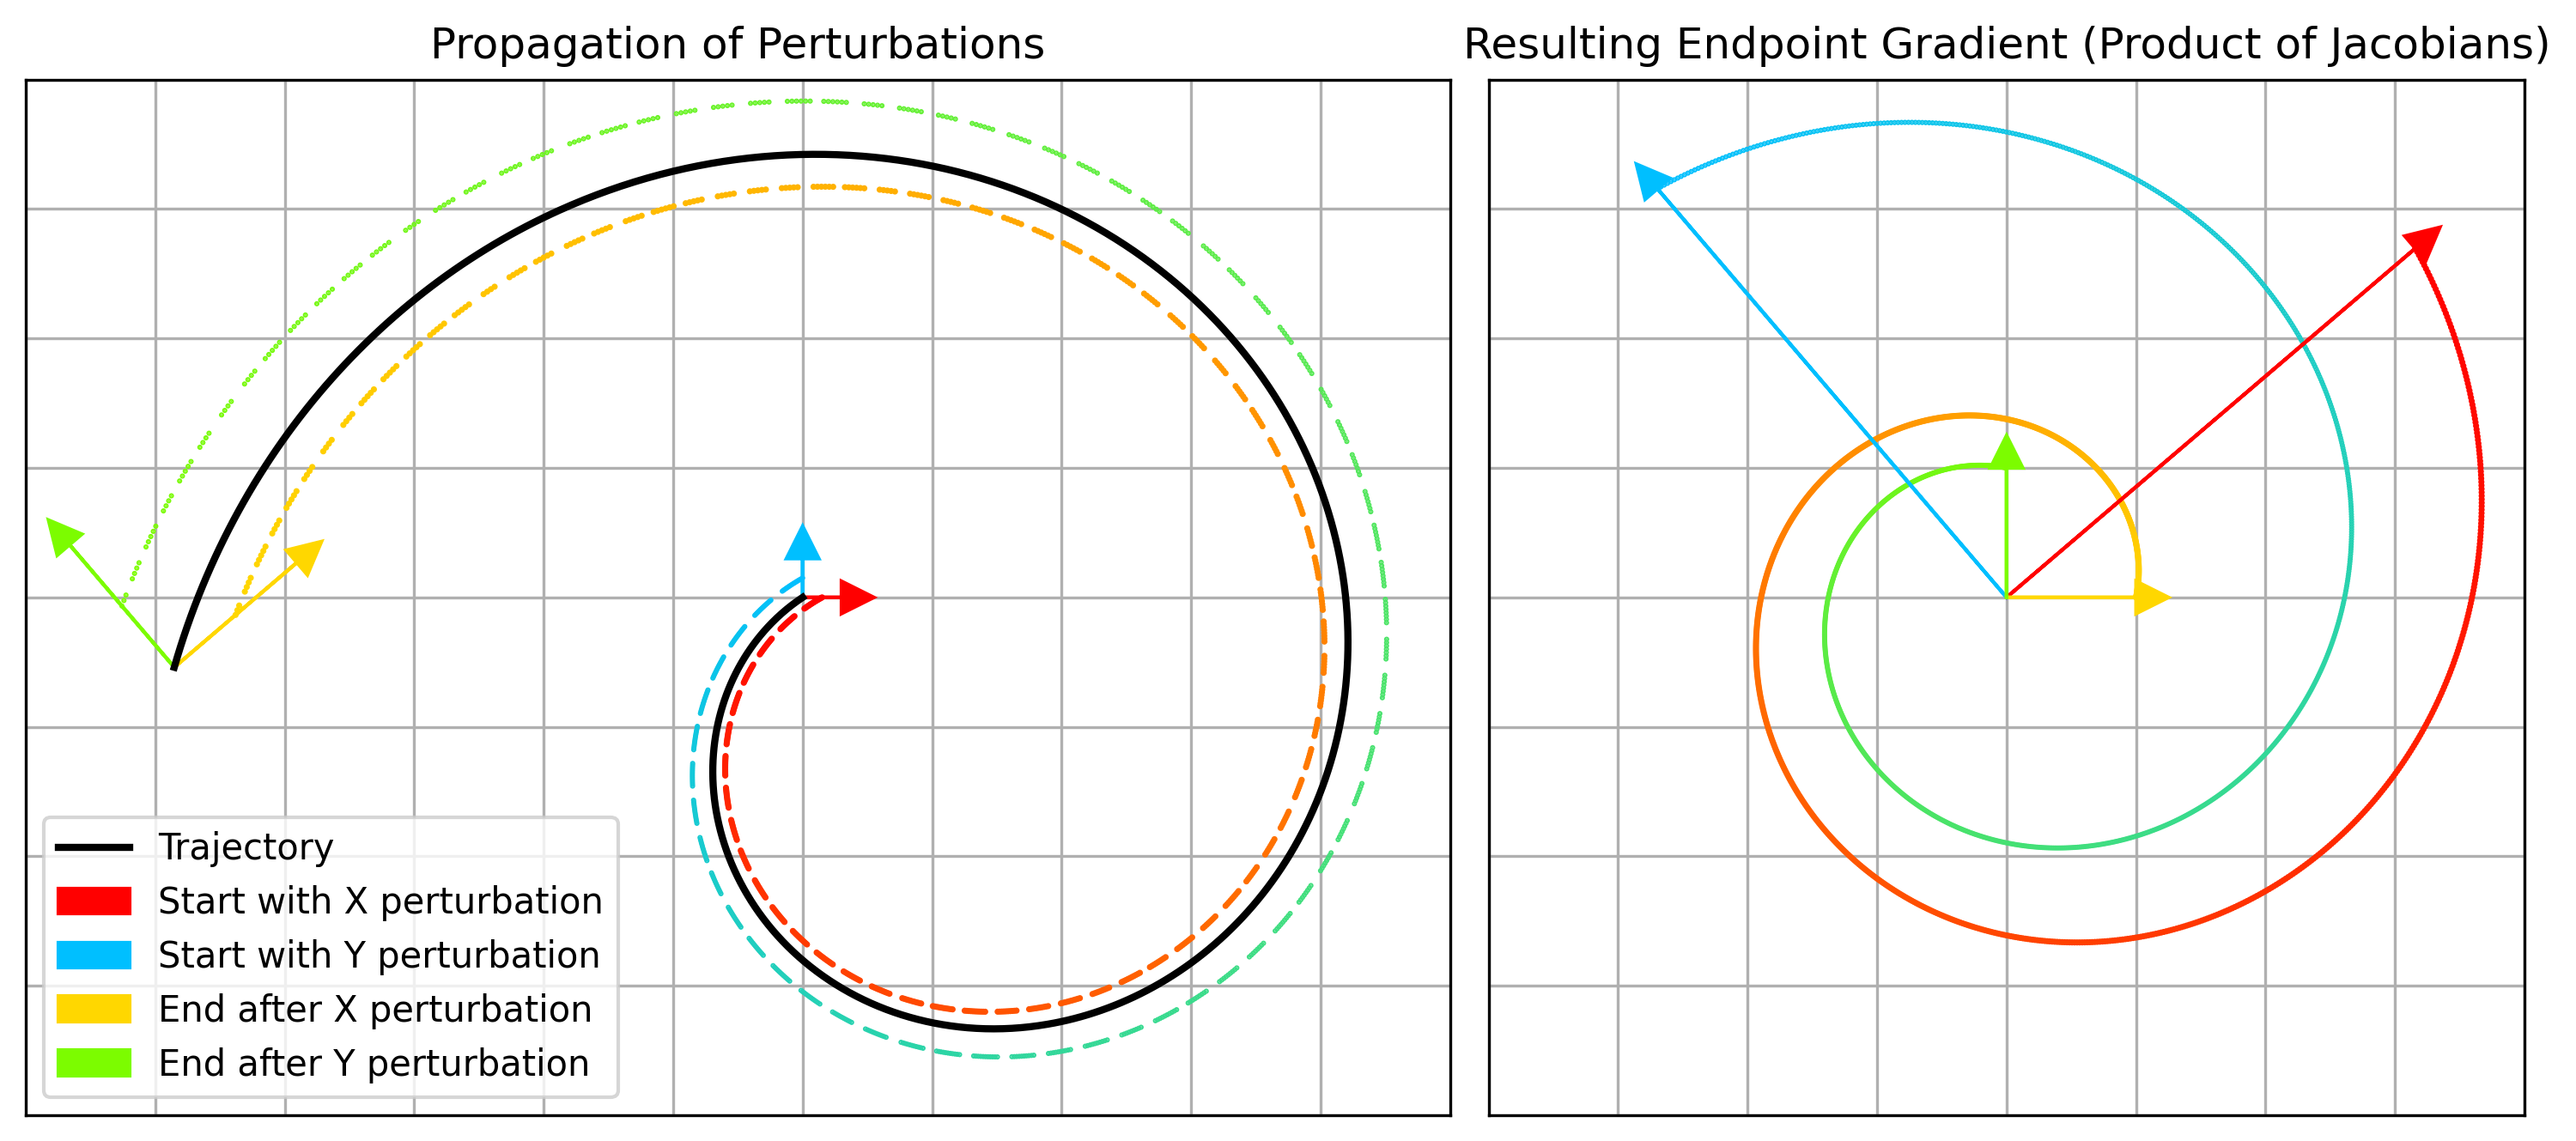

In [ ]:
# Plotting
# fig, ax = plt.subplots(1,2, figsize=(15, 10), dpi=100)

fig = plt.figure(figsize=(10, 6), dpi=300)

gs = gridspec.GridSpec(1, 2, width_ratios=[11/8-0, 1])  # The first plot is twice as wide

ax1 = fig.add_subplot(gs[0])  # First subplot
ax2 = fig.add_subplot(gs[1])  # Second subplot


ax1.grid()
ax1.set_axisbelow(True)

cfrac = np.linspace(0, 1, path_x.shape[0])
cmap_x = LinearSegmentedColormap.from_list("red_to_yellow", ["red", "gold"])
cmap_y = LinearSegmentedColormap.from_list("red_to_yellow", ["deepskyblue", "lawngreen"])

def dashed_alpha(x, mod_dist=0.012, threshold=0.008):
    dists = np.concat([[0], np.linalg.norm(x[1:] - x[:-1], axis=1)])
    dists = np.cumsum(dists)
    dists = dists / np.max(dists)
    alpha = np.mod(dists, mod_dist) < threshold
    return alpha

# dists = np.concat([[0], np.linalg.norm(path[1:] - path[:-1], axis=1)])
# dists = np.cumsum(dists)
# dists = dists / np.max(dists)

# alpha = dashed_alpha(path)

ax1.plot(path[:,0], path[:,1], lw=2, color='k', alpha=1, label='Trajectory')
ax1.scatter(path_x[:,0], path_x[:,1], c=cfrac, alpha=dashed_alpha(path_x), s=0.5, cmap=cmap_x)
ax1.scatter(path_y[:,0], path_y[:,1], c=cfrac, alpha=dashed_alpha(path_y), s=0.2, cmap=cmap_y)
# ax1.plot([], [], '--', color='red', label='Path + epsilon_x')
# ax1.plot([], [], '--', color='deepskyblue', label='Path + epsilon_x')

ax1.arrow(*path[0], *(arrow_len*ep_x), color='red', head_width=0.25, head_length=0.25, label='Start with X perturbation')
ax1.arrow(*path[0], *(arrow_len*ep_y), color='deepskyblue', head_width=0.25, head_length=0.25, label='Start with Y perturbation')

ep1_x = path_x[-1] - path[-1]
ep1_y = path_y[-1] - path[-1]

ax1.arrow(*path[-1], *(arrow_len*ep1_x), color='gold', head_width=0.25, head_length=0.25, label='End after X perturbation')
ax1.arrow(*path[-1], *(arrow_len*ep1_y), color='lawngreen', head_width=0.25, head_length=0.25, label='End after Y perturbation')

ep1_x_cum = cum_grad @ ep_x
ep1_y_cum = cum_grad @ ep_y

print(f'Finite difference: {ep1_x}')
print(f'Cumulative Gradient: {ep1_x_cum}')
print(f'Finite difference: {ep1_y}')
print(f'Cumulative Gradient: {ep1_y_cum}')
print(f'Error = {np.linalg.norm(ep1_x - ep1_x_cum)}')

# ax1.arrow(*(path[-1]), *(arrow_len*ep1_x_cum), color='g', head_width=0.125, head_length=0.125)
# ax1.arrow(*(path[-1]), *(arrow_len*ep1_y_cum), color='g', head_width=0.125, head_length=0.125)

ax1.tick_params(
    axis='both',       # x and y axis
    which='both',      # major and minor ticks
    bottom=False,      # remove bottom ticks
    top=False,         # remove top ticks
    left=False,        # remove left ticks
    right=False,       # remove right ticks
    labelbottom=False, # remove x-axis numbers
    labelleft=False    # remove y-axis numbers
)


ax1.set_aspect('equal')
ax1.set_xticks(np.arange(-7, 4, 1))
ax1.set_yticks(np.arange(-5, 6, 1))
ax1.set_xlim(-7, 4)
ax1.set_ylim(-3, 5)
ax1.legend(loc='lower left')
ax1.set_title('Propagation of Perturbations')

# Plotting Jacobians

ax2.scatter(jacobians[:, 0, 0], jacobians[:, 1, 0], c=cfrac, alpha=dashed_alpha(jacobians[:,:,0], threshold=1), s=0.5, cmap=cmap_x)
ax2.scatter(jacobians[:, 0, 1], jacobians[:, 1, 1], c=cfrac, alpha=dashed_alpha(jacobians[:,:,1], threshold=1), s=0.2, cmap=cmap_y)


ax2.arrow(0, 0, *jacobians[0,:,0], color='red', head_width=0.25, head_length=0.25, label='Start with X perturbation')
ax2.arrow(0, 0, *jacobians[0,:,1], color='deepskyblue', head_width=0.25, head_length=0.25, label='Start with Y perturbation')

ax2.arrow(0, 0, *jacobians[-1,:,0], color='gold', head_width=0.25, head_length=0.25, label='Start with X perturbation')
ax2.arrow(0, 0, *jacobians[-1,:,1], color='lawngreen', head_width=0.25, head_length=0.25, label='Start with Y perturbation')

ax2.set_aspect('equal')
ax2.set_xlim(-4, 4)
ax2.set_ylim(-4, 4)
ax2.tick_params(
    axis='both',       # x and y axis
    which='both',      # major and minor ticks
    bottom=False,      # remove bottom ticks
    top=False,         # remove top ticks
    left=False,        # remove left ticks
    right=False,       # remove right ticks
    labelbottom=False, # remove x-axis numbers
    labelleft=False    # remove y-axis numbers
)
ax2.grid()
ax2.set_axisbelow(True)
ax2.set_title('Resulting Endpoint Gradient (Product of Jacobians)')


plt.tight_layout()
# plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.05)
plt.show()

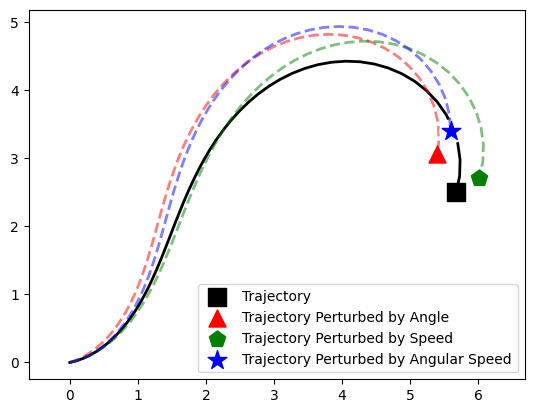

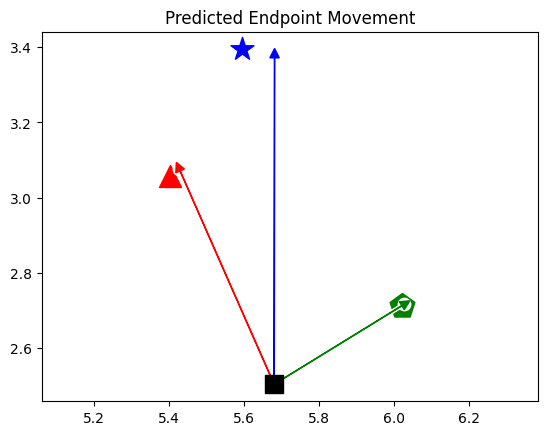

Finite difference: [-0.27825363  0.55462075  0.1         0.          0.        ]
Cumulative Gradient: [-0.25029068  0.56807117  0.1         0.          0.        ]
Finite difference: [0.33995211 0.20918324 0.         0.1        0.        ]
Cumulative Gradient: [0.33995211 0.20918324 0.         0.1        0.        ]
Finite difference: [-0.08436651  0.89251971  0.275       0.          0.05      ]
Cumulative Gradient: [0.00113667 0.86901606 0.275      0.         0.05      ]
Error = 0.03102967315566198
Error = 1.3637000969055898e-15
Error = 0.0886747774512362
[[ 1.          0.         -2.5029068   3.39952105  0.0227335 ]
 [ 0.          1.          5.68071168  2.09183241 17.38032123]
 [ 0.          0.          1.          0.          5.5       ]
 [ 0.          0.          0.          1.          0.        ]
 [ 0.          0.          0.          0.          1.        ]]


In [ ]:
def v_prime_components(v, dt):
    dt2 = dt*dt/2

    x = v[0]    # x coordinate
    y = v[1]    # y coordinate
    a = v[2]    # angle
    s = v[3]    # speed
    w = v[4]    # angular speed

    A1 = np.array([x, y, a, s, w])
    A2 = np.array([s*np.cos(a), s*np.sin(a), w, 0, 0])
    A3 = np.array([-s*w*np.sin(a), s*w*np.cos(a), 0, 0, 0])
    A = A1 + dt*A2 + dt2*A3

    B2 = np.array([0, 0, 0, 1, 0])                  # <0, 0, 0, phi, 0>
    B3 = np.array([np.cos(a), np.sin(a), 0, 0, 0])  # <phi*np.cos(a), phi*np.sin(a), 0, 0, 0>
    B = dt*B2 + dt2*B3

    C2 = np.array([0, 0, 0, 0, 1])                  # <0, 0, 0, 0, psi>
    C3 = np.array([0, 0, 1, 0, 0])                  # <0, 0, psi, 0, 0>
    C = dt*C2 + dt2*C3

    return A, B, C

def jacobian_components(v, dt):
    dt2 = dt*dt/2

    x = v[0]    # x coordinate
    y = v[1]    # y coordinate
    a = v[2]    # angle
    s = v[3]    # speed
    w = v[4]    # angular speed

    J_A1 = np.eye(5)
    J_A2 = np.array(
       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [-s*np.sin(a), s*np.cos(a), 0, 0, 0],
        [np.cos(a), np.sin(a), 0, 0, 0],
        [0, 0, 1, 0, 0]]
    ).T
    J_A3 = np.array(
       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [-s*w*np.cos(a), -s*w*np.sin(a), 0, 0, 0],
        [-w*np.sin(a), w*np.cos(a), 0, 0, 0],
        [-s*np.sin(a), s*np.cos(a), 0, 0, 0]]
    ).T

    J_A = J_A1 + dt*J_A2 + dt2*J_A3

    # J_B2 is zero
    J_B3 = np.array(        # B3 = <phi*np.cos(a), phi*np.sin(a), 0, 0, 0>
       [[0, 0, 0, 0, 0],                    # d/dx[B3]
        [0, 0, 0, 0, 0],                    # d/dy[B3]
        [-np.sin(a), np.cos(a), 0, 0, 0],   # d/da[B3]
        [0, 0, 0, 0, 0],                    # d/ds[B3]
        [0, 0, 0, 0, 0]]                    # d/dw[B3]
    ).T
    J_B = dt2*J_B3

    # J_C2 is zero
    # J_C3 is zero
    # J_C is zero

    return J_A, J_B

def euler_step2(v, dt, phi=0, psi=0):
    A, B, C = v_prime_components(v, dt)
    return A + phi*B + psi*C

def compute_path(v, t, phi=0, psi=0, compute_jacs=False):
    paths = np.zeros((len(t), len(v)))
    paths[0] = v

    n = v.shape[0]

    for i in range(len(t)-1):
        A = euler_step2(paths[i], t[i+1] - t[i], phi=phi, psi=psi)
        paths[i+1] = A

    jacobians = None
    if compute_jacs:
        jacobians = np.zeros((len(t), n, n))

        jacobians[-1] = np.eye(n)
        for i in range(len(t)-2, -1, -1):
            J_A, J_B = jacobian_components(paths[i], t[i+1] - t[i])
            J = J_A + phi*J_B
            jacobians[i] = jacobians[i+1] @ J

        return paths, jacobians
    return paths

v0 = np.array([0, 0, 0.2, 1, 1])
epsilon = 0.05
arrow_len = 0.3 / epsilon

ep_a = epsilon * np.array([0, 0, 2, 0, 0])
ep_s = epsilon * np.array([0, 0, 0, 2, 0])
ep_w = epsilon * np.array([0, 0, 0, 0, 1])

dt_max = 0.1
t0 = 0
t1 = 5.5
n_ts = int((t1 - t0) / dt_max)
ts = np.linspace(t0, t1, n_ts)

phi = 0.25
psi = -0.5
path, jacobians = compute_path(v0, ts, phi, psi, compute_jacs=True)
path_a = compute_path(v0 + ep_a, ts, phi, psi)
path_s = compute_path(v0 + ep_s, ts, phi, psi)
path_w = compute_path(v0 + ep_w, ts, phi, psi)

plt.plot(path[:,0], path[:,1], lw=2, color='k', alpha=1)
plt.plot(path_a[:,0], path_a[:,1], '--', lw=2, color='r', alpha=0.5)
plt.plot(path_s[:,0], path_s[:,1], '--', lw=2, color='g', alpha=0.5)
plt.plot(path_w[:,0], path_w[:,1], '--', lw=2, color='b', alpha=0.5, zorder=3)
plt.scatter(path[-1,0], path[-1,1], marker='s', color='k', s=150, label='Trajectory')
plt.scatter(path_a[-1,0], path_a[-1,1], marker='^', color='r', s=150, label='Trajectory Perturbed by Angle')
plt.scatter(path_s[-1,0], path_s[-1,1], marker='p', color='g', s=150, label='Trajectory Perturbed by Speed')
plt.scatter(path_w[-1,0], path_w[-1,1], marker='o', color='w', s=280, zorder=2)
plt.scatter(path_w[-1,0], path_w[-1,1], marker='*', color='b', s=200, zorder=3, label='Trajectory Perturbed by Angular Speed')

plt.axis('equal')
plt.legend(loc='lower right')
plt.show()



ep1_a = path_a[-1] - path[-1]
ep1_s = path_s[-1] - path[-1]
ep1_w = path_w[-1] - path[-1]
ep1_a_cum = jacobians[0] @ ep_a
ep1_s_cum = jacobians[0] @ ep_s
ep1_w_cum = jacobians[0] @ ep_w

# plot 2

plt.scatter(path[-1,0], path[-1,1], marker='s', color='k', s=150, zorder=5, label='Trajectory')
plt.scatter(path_a[-1,0], path_a[-1,1], marker='^', color='r', s=250, label='Trajectory Perturbed by Angle')
plt.scatter(path_s[-1,0], path_s[-1,1], marker='p', color='g', s=350, label='Trajectory Perturbed by Speed')
plt.scatter(path_w[-1,0], path_w[-1,1], marker='*', color='b', s=300, label='Trajectory Perturbed by Angular Speed')


plt.arrow(*path[-1,0:2], *ep1_a_cum[0:2], color='r', head_width=0.025, head_length=0.025, zorder=3)
plt.arrow(*path[-1,0:2], *ep1_s_cum[0:2], color='g', head_width=0.025, head_length=0.025, zorder=3)
plt.arrow(*path[-1,0:2], *ep1_w_cum[0:2], color='b', head_width=0.025, head_length=0.025, zorder=3)

plt.arrow(*path[-1,0:2], *ep1_s_cum[0:2], color='w', linewidth=3, head_width=0.0, head_length=0.0, zorder=2)

plt.scatter(*(path[-1,0:2] + ep1_s_cum[0:2] + np.array([0.005, 0.005])), marker='o', color='w', s=80, zorder=2)
plt.scatter(*(path[-1,0:2] + ep1_a_cum[0:2] + np.array([-0.003, 0.005])), marker='o', color='w', s=80, zorder=2)


plt.axis('equal')
plt.title('Predicted Endpoint Movement')

plt.show()

# Research Affine Transformations
# Linear approximation is good for very small epsilons

print(f'Finite difference: {ep1_a}')
print(f'Cumulative Gradient: {ep1_a_cum}')
print(f'Finite difference: {ep1_s}')
print(f'Cumulative Gradient: {ep1_s_cum}')
print(f'Finite difference: {ep1_w}')
print(f'Cumulative Gradient: {ep1_w_cum}')

print(f'Error = {np.linalg.norm(ep1_a - ep1_a_cum)}')
print(f'Error = {np.linalg.norm(ep1_s - ep1_s_cum)}')
print(f'Error = {np.linalg.norm(ep1_w - ep1_w_cum)}')

# Error = 0.006832747085372277
# Error = 1.1243577791325062e-15
# Error = 0.016134222768151824

print(jacobians[0])

Itteration 100, Loss = 0.5626092813877167
Itteration 200, Loss = 0.40323643160322553
Itteration 300, Loss = 0.31495375791589725
Itteration 400, Loss = 0.25181990772695495
Itteration 500, Loss = 0.20490551957930703
Itteration 600, Loss = 0.16930306755640726
Itteration 700, Loss = 0.1417931629610691
Itteration 800, Loss = 0.12018806892175278
Itteration 900, Loss = 0.1029692819369321
Itteration 1000, Loss = 0.08906274971965673
Itteration 1100, Loss = 0.07769536708655829
Itteration 1200, Loss = 0.06830153307169035
Itteration 1300, Loss = 0.060461177814829986
Itteration 1400, Loss = 0.05385793694756054
Itteration 1500, Loss = 0.048250453891061834
Itteration 1600, Loss = 0.04345238140075147
Itteration 1700, Loss = 0.039318240517423074
Itteration 1800, Loss = 0.03573328346851198
Itteration 1900, Loss = 0.03260613285525956
Itteration 2000, Loss = 0.029863371945417955
Itteration 2100, Loss = 0.02744552365550438
Itteration 2200, Loss = 0.025304029815586312
Itteration 2300, Loss = 0.0233989591144

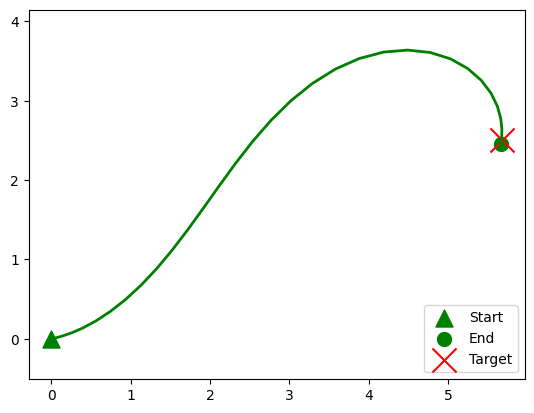

In [ ]:
def compute_path(v0, F_mat, t, target, compute_jacs=False):
    V_mat = np.zeros((len(t), 5))
    V_mat[0] = v0

    for i in range(len(t)-1):
        A = euler_step2(V_mat[i], t[i+1] - t[i], phi=F_mat[i,0], psi=F_mat[i,1])
        V_mat[i+1] = A

    loss = 1/5 * np.sum((V_mat[-1] - target)**2)

    jacobians = None
    if compute_jacs:
        jacobians = np.zeros((len(t), 5, 5))

        jacobians[-1] = np.eye(5)
        for i in range(len(t)-2, -1, -1):
            J_A, J_B = jacobian_components(V_mat[i], t[i+1] - t[i])
            J = J_A + phi*J_B
            jacobians[i] = jacobians[i+1] @ J

        return V_mat, jacobians, loss
    return V_mat, loss

def grad_v_plus_1(V_mat, t):
    x = V_mat[:,0]
    y = V_mat[:,1]
    a = V_mat[:,2]
    s = V_mat[:,3]
    w = V_mat[:,4]
    _0 = np.zeros_like(x)
    _1 = np.ones_like(x)
    dt = (t[1:] - t[:-1])[:,np.newaxis]
    dt2 = dt*dt/2

    B2 = np.stack([_0, _0, _0, _1, _0], axis=1)
    B3 = np.stack([np.cos(a), np.sin(a), _0, _0, _0], axis=1)
    B = dt*B2 + dt2*B3

    C2 = np.stack([_0, _0, _0, _0, _1], axis=1)
    C3 = np.stack([_0, _0, _1, _0, _0], axis=1)
    C = dt*C2 + dt2*C3

    grad = np.stack([B, C], axis=1)
    return grad


v0 = np.array([0, 0, 0.2, 1, 1])
target = np.array([5.68071168, 2.5029068, -1.8625, 2.375, -1.75])
t0 = 0
t1 = 1       # designed for 5.5
dt_max = 0.03
n_ts = int((t1 - t0) / dt_max)
ts = np.linspace(t0, t1, n_ts)

F_mat = np.zeros((n_ts-1, 2))
V_mat, Jac_cum, loss = None, None, None

losses = []

for i in range(5000):
    V_mat, Jac_cum, loss = compute_path(v0, F_mat, ts, target, compute_jacs=True)
    losses.append(loss)
    if i % 100 == 99:
        print(f'Itteration {i+1}, Loss = {loss}')

    YT = ((2/5) * (V_mat[-1] - target))
    V1_grad = grad_v_plus_1(V_mat[:-1,:], ts)

    gradLoss = np.einsum('nij,nmj->nmi', Jac_cum[1:], V1_grad)
    gradLoss = np.einsum('j,nij->ni', YT, gradLoss)

    F_mat = F_mat - np.sqrt(loss)/0.04 * gradLoss

plt.plot(V_mat[:,0], V_mat[:,1], lw=2, color='g', alpha=1)
plt.scatter(v0[0], v0[1], marker='^', color='g', s=150, label='Start')
plt.scatter(V_mat[-1,0], V_mat[-1,1], marker='o', color='g', s=100, label='End')

plt.scatter(target[0], target[1], marker='x', color='r', s=300, label='Target')
plt.axis('equal')
plt.legend(loc='lower right')
plt.show()

# Iteration 10000, Loss = 0.0012985975520752435


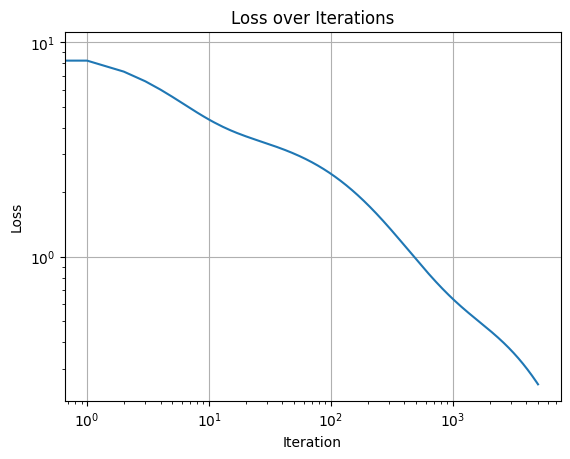

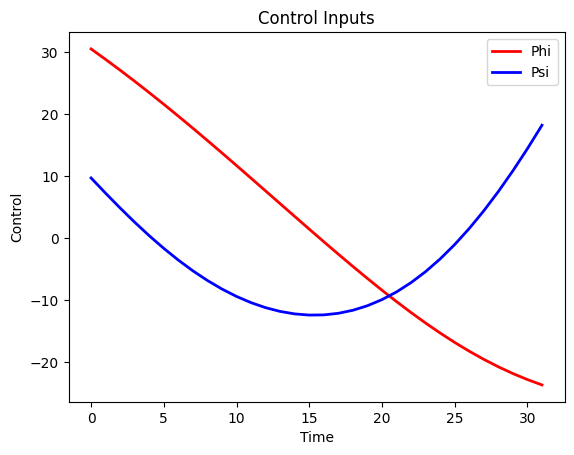

In [ ]:
plt.plot(losses)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.grid()
plt.show()

plt.plot(F_mat[:,0], lw=2, color='r', alpha=1, label='Phi')
plt.plot(F_mat[:,1], lw=2, color='b', alpha=1, label='Psi')
plt.xlabel('Time')
plt.ylabel('Control')
plt.title('Control Inputs')
plt.legend(loc='upper right')
plt.show()